# Text Summarizer.

In [ ]:
!pip install evaluate
!pip install rouge_score

In [54]:
import os
import re
import sys
import json
import wandb
import torch
import evaluate
import itertools
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from datasets import Dataset, DatasetDict
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

from transformers import BartTokenizer, BartForConditionalGeneration

In [3]:
wandb.init(mode="disabled")

## Load Dataset.

In [4]:
def json_to_dataset(dataset_path):
    """
    Load JSON file into HuggingFace Dataset.
    """
    with open(dataset_path, "r", encoding="utf-8") as f:
        dataset = json.load(f)
    dataset = Dataset.from_list(dataset)
    return dataset


# Create a unified dataset
train_path = "../input/samsum/train.json"
valid_path = "../input/samsum/val.json"
test_path = "../input/samsum/test.json"

train_dataset = json_to_dataset(train_path)
valid_dataset = json_to_dataset(valid_path)
test_dataset = json_to_dataset(test_path)

dataset = DatasetDict({
    "train": train_dataset,
    "valid": valid_dataset,
    "test": test_dataset
})

## Analyze Dataset.

In [10]:
# Explore dataset structure
print("Train Dataset Size:", len(dataset["train"]))
print("Valid Dataset Size:", len(dataset["valid"]))
print("Test Dataset Size:", len(dataset["test"]))

# Display dataset sample
print("\nDataset Sample:")
print("Id:", dataset["train"][0]["id"])
print("Summary:", dataset["train"][0]["summary"])
print("\nDialogue:\n" + dataset["train"][0]["dialogue"])

Train Dataset Size: 14732
Valid Dataset Size: 818
Test Dataset Size: 819

Dataset Sample:
Id: 13818513
Summary: Amanda baked cookies and will bring Jerry some tomorrow.

Dialogue:
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)


In [11]:
def analyze_lengths(dataset, dataset_label):
    """
    Analyze text data lengths.
    """
    data = dataset[dataset_label]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    print(f"Analyze lengths for '{dataset_label}':")
    print(f"- Dialogues: Mean={sum(dialogue_lengths) / len(dialogue_lengths):.2f}, Max={max(dialogue_lengths)}, Min={min(dialogue_lengths)}")
    print(f"- Summaries: Mean={sum(summary_lengths) / len(summary_lengths):.2f}, Max={max(summary_lengths)}, Min={min(summary_lengths)}\n")
    return

# Analyze lengths
analyze_lengths(dataset, "train")
analyze_lengths(dataset, "valid")
analyze_lengths(dataset, "test")

Analyze lengths for 'train':
- Dialogues: Mean=93.79, Max=803, Min=0
- Summaries: Mean=20.32, Max=64, Min=1

Analyze lengths for 'valid':
- Dialogues: Mean=91.64, Max=540, Min=10
- Summaries: Mean=20.28, Max=59, Min=3

Analyze lengths for 'test':
- Dialogues: Mean=95.51, Max=516, Min=9
- Summaries: Mean=20.02, Max=58, Min=3



In [12]:
def find_texts_below_length(dataset, dataset_label, max_length=1):
    """
    Find texts with lengths below or equal to a specified value.
    """
    data = dataset[dataset_label]
    ids = data["id"]
    summaries = data["summary"]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    # Identify texts
    short_dialogues = [(ids[i], dialogues[i], summaries[i]) for i, length in enumerate(dialogue_lengths) if length <= max_length]
    short_summaries = [(ids[i], summaries[i], dialogues[i]) for i, length in enumerate(summary_lengths) if length <= max_length]
    # Display results
    print(f"Analyze texts with length <= {max_length} for '{dataset_label}':")
    print("=== Dialogues ===")
    for i, (id, dialogue, summary) in enumerate(short_dialogues):
        print(f"{i+1}. (id {id}) Dialogue ({len(dialogue.split())} words):\n{dialogue}")
        print(f"   Associated Summary ({len(summary.split())} words): {summary}\n")
    print("\n=== Summaries ===")
    for i, (id, summary, dialogue) in enumerate(short_summaries):
        print(f"{i+1}. (id {id}) Summary ({len(summary.split())} words): {summary}")
        print(f"   Associated Dialogue ({len(dialogue.split())} words):\n{dialogue}\n")
    print()
    return


# Analyze extreme texts (min & max)
find_texts_below_length(dataset, "train", 2)
find_texts_below_length(dataset, "valid", 2)
find_texts_below_length(dataset, "test", 2)

Analyze texts with length <= 2 for 'train':
=== Dialogues ===
1. (id 13828807) Dialogue (0 words):

   Associated Summary (6 words): problem with visualization of the content


=== Summaries ===
1. (id 13810635) Summary (1 words): test
   Associated Dialogue (65 words):
Rivka: How do you like your neighborhood
Coen: I dont like them much
Rivka: Why is that so?
Coen: They are so mean like they play songs at loud music even late night
Rivka: Maybe you can request them to slow down the volume
Coen: We have tried to do so
Rivka: Why dont you ask your mother to visit their place?
Coen: I will

2. (id 13727708) Summary (1 words): yyy
   Associated Dialogue (30 words):
Sue: WOW! you look awesome in this picture
Joanna: The dress covered it up
Sue: Are you coming back?
Joanna: Yeah, I'm in a hurry
Joanna: Speak to you later!

3. (id 13864563) Summary (2 words): Manchester won.
   Associated Dialogue (9 words):
Parker: I told you 
Laila: What?
Wisner: Manchester won... 

4. (id 13681708) Summar

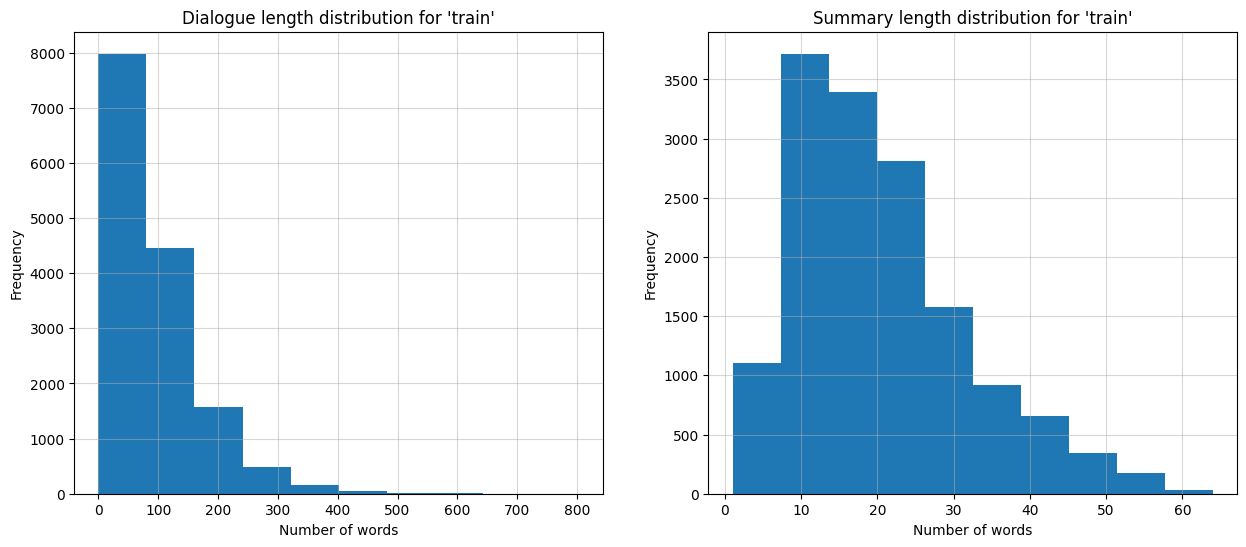

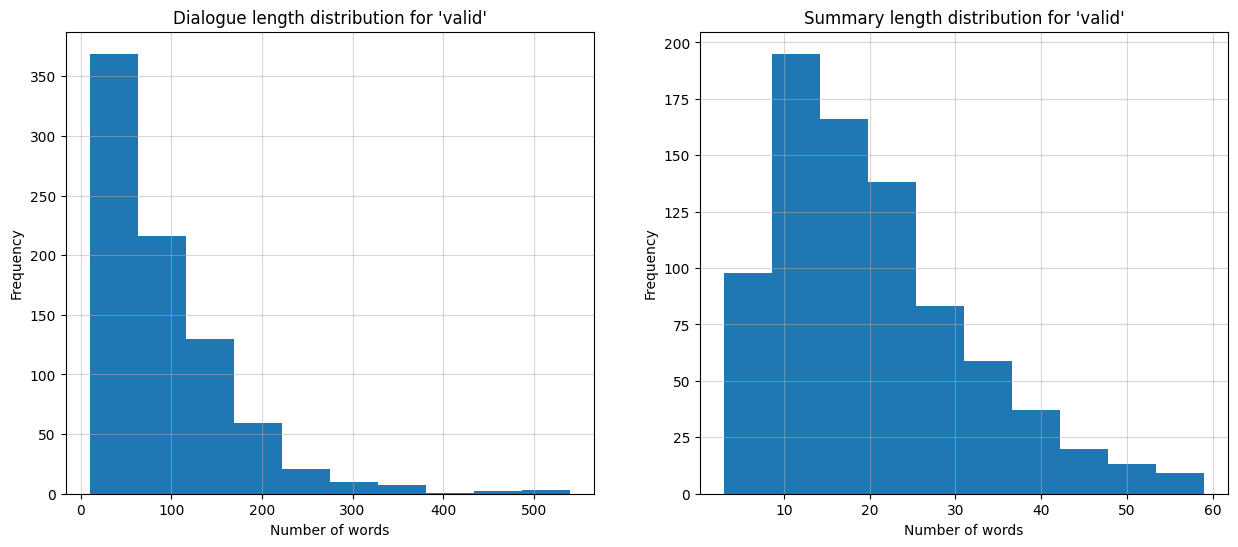

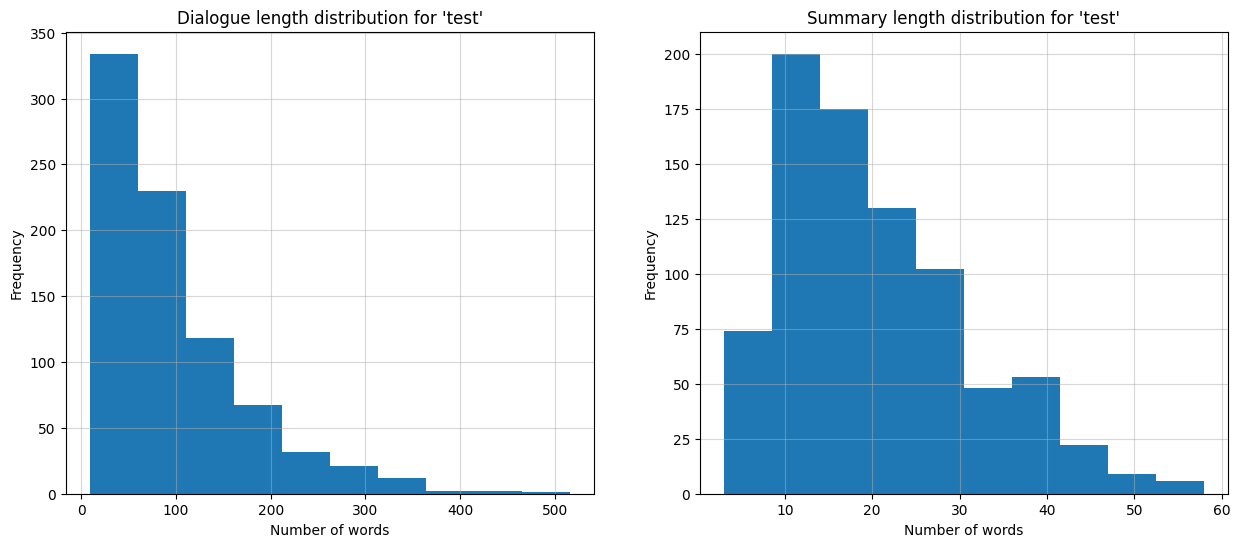

In [13]:
def plot_length_distribution(dataset, dataset_label):
    """
    Plot text lengths distribution.
    """
    data = dataset[dataset_label]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    # Plot dialogue length distribution
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.hist(dialogue_lengths)
    plt.title(f"Dialogue length distribution for '{dataset_label}'")
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.5)
    # Plot summary length distribution
    plt.subplot(1, 2, 2)
    plt.hist(summary_lengths)
    plt.title(f"Summary length distribution for '{dataset_label}'")
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.5)
    plt.show()
    return

# Graficar para diálogos y resúmenes
plot_length_distribution(dataset, "train")
plot_length_distribution(dataset, "valid")
plot_length_distribution(dataset, "test")

In [14]:
def analyze_word_frequency(dataset, dataset_label, top_n=10):
    """
    Count most common words.
    """
    data = dataset[dataset_label]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_words = list(itertools.chain(*[sample.split() for sample in dialogues]))    
    summary_words = list(itertools.chain(*[sample.split() for sample in summaries]))
    # Get word frequency
    dialogue_word_counts = Counter(dialogue_words)
    summary_word_counts = Counter(summary_words)
    dialogue_most_common = dialogue_word_counts.most_common(top_n)
    summary_most_common = summary_word_counts.most_common(top_n)
    print(f"Analyze word frequency for '{dataset_label}':")
    print("=== Dialogues ===")
    for word, count in dialogue_most_common:
        print(f"{word}: {count}")
    print("\n=== Summaries ===")
    for word, count in summary_most_common:
        print(f"{word}: {count}")
    print()
    return


# Analyze most common words
analyze_word_frequency(dataset, "train")
analyze_word_frequency(dataset, "valid")
analyze_word_frequency(dataset, "test")

Analyze word frequency for 'train':
=== Dialogues ===
I: 37592
you: 31617
the: 29897
to: 28658
a: 21640
and: 15311
it: 14302
for: 11546
in: 10723
of: 10267

=== Summaries ===
to: 11567
and: 10138
the: 9871
a: 7366
is: 6811
will: 6653
for: 4638
in: 4042
at: 3693
her: 3096

Analyze word frequency for 'valid':
=== Dialogues ===
I: 2008
you: 1672
the: 1619
to: 1489
a: 1157
and: 807
it: 763
for: 658
in: 602
is: 560

=== Summaries ===
to: 650
and: 570
the: 562
a: 413
is: 392
will: 334
for: 277
in: 241
at: 227
her: 198

Analyze word frequency for 'test':
=== Dialogues ===
I: 2135
you: 1715
the: 1680
to: 1552
a: 1230
and: 900
it: 756
for: 638
in: 590
is: 577

=== Summaries ===
to: 662
and: 555
the: 513
a: 417
will: 372
is: 364
in: 217
for: 204
at: 202
her: 180



## Preprocess Dataset.

#### Preprocessing Decision: Removing Short Texts.
During the exploratory data analysis, it was identified that texts with a length of 1 word or less are problematic. These texts are either empty (length 0) or nonsensical (e.g., placeholders like "yyy"). Removing them is crucial because they do not provide meaningful information for training the model. Keeping these samples could introduce noise and negatively impact model performance.

Thus, as part of the preprocessing steps, it was decided to remove all samples with a dialogue or summary length of 1 or fewer words. This will ensure that only valid and meaningful texts are used for training, resulting in a cleaner and more reliable dataset.

In [5]:
def remove_short_texts(dataset, dataset_label, min_length=2):
    """
    Remove samples where the length of dialogue or summary is < min_length.
    """
    data = dataset[dataset_label]
    ids = data["id"]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    # Identify samples with dialogue or summary length <= min_length
    valid_indices = [
        i for i, (dialogue_len, summary_len) in enumerate(zip(dialogue_lengths, summary_lengths))
        if dialogue_len >= min_length and summary_len >= min_length
    ]
    filtered_ids = [ids[i] for i in valid_indices]
    filtered_dialogues = [dialogues[i] for i in valid_indices]
    filtered_summaries = [summaries[i] for i in valid_indices]
    # Create new dataset with filtered samples
    filtered_data = {
        "id": filtered_ids,
        "dialogue": filtered_dialogues,
        "summary": filtered_summaries
    }
    filtered_data = Dataset.from_dict(filtered_data)
    print(f"Filtered '{dataset_label}' dataset contains {len(filtered_dialogues)} samples.")
    return filtered_data


# Remove short texts (length <= 1)
filtered_train_dataset = remove_short_texts(dataset, "train")
filtered_valid_dataset = remove_short_texts(dataset, "valid")
filtered_test_dataset = remove_short_texts(dataset, "test")

filtered_dataset = DatasetDict({
    "train": filtered_train_dataset,
    "valid": filtered_valid_dataset,
    "test": filtered_test_dataset
})

Filtered 'train' dataset contains 14729 samples.
Filtered 'valid' dataset contains 818 samples.
Filtered 'test' dataset contains 819 samples.


#### Preprocessing Decision: Handling Extra Spaces, Tags, and Line Breaks.
During preprocessing, several steps were taken to clean and standardize the text, including removing extra spaces, stripping leading and trailing spaces, and converting the text to lowercase. Additionally, carriage return characters (\r) were removed, and line feed characters (\n) were replaced with the <speaker> marker to indicate changes in speakers in dialogues. These actions are expected to help ensure uniformity and improve the model’s ability to process the data effectively, while preserving the structure of the conversations.

However, certain elements were left unchanged. XML tags, such as \<file_gif\>, were retained, as they may provide important contextual information despite not being meaningful on their own.

In [6]:
def preprocess_texts(dataset, dataset_label):
    """
    Preprocess the dialogue and summary texts by:
    - Replacing \r with '' to remove carriage returns.
    - Replacing \n with <speaker> to mark changes in speaker.
    - Removing extra spaces.
    - Stripping leading/trailing spaces.
    - Converting to lowercase.
    """
    data = dataset[dataset_label]
    ids = data["id"]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    processed_dialogues = [
        re.sub(r'\s+', ' ', re.sub(r"\r", "", re.sub(r"\n", " <speaker> ", dialogue))).strip().lower()
        for dialogue in dialogues
    ]
    processed_summaries = [summary.strip().lower() for summary in summaries]    
    # Create new dataset with filtered samples
    filtered_data = {
        "id": ids,
        "dialogue": processed_dialogues,
        "summary": processed_summaries
    }
    filtered_data = Dataset.from_dict(filtered_data)
    print(f"Preprocessing completed for '{dataset_label}' dataset.")
    return filtered_data


# Preprocess texts
filtered_train_dataset = preprocess_texts(filtered_dataset, "train")
filtered_valid_dataset = preprocess_texts(filtered_dataset, "valid")
filtered_test_dataset = preprocess_texts(filtered_dataset, "test")

filtered_dataset = DatasetDict({
    "train": filtered_train_dataset,
    "valid": filtered_valid_dataset,
    "test": filtered_test_dataset
})

Preprocessing completed for 'train' dataset.
Preprocessing completed for 'valid' dataset.
Preprocessing completed for 'test' dataset.


In [17]:
# Explore filtered dataset structure
print("Train Filtered Dataset Size:", len(filtered_dataset["train"]))
print("Valid Filtered Dataset Size:", len(filtered_dataset["valid"]))
print("Test Filtered Dataset Size:", len(filtered_dataset["test"]))

# Display filtered dataset sample
print("\nFiltered Dataset Sample:")
print("Id:", filtered_dataset["train"][0]["id"])
print("Summary:", filtered_dataset["train"][0]["summary"])
print("\nDialogue:\n" + filtered_dataset["train"][0]["dialogue"])

Train Filtered Dataset Size: 14729
Valid Filtered Dataset Size: 818
Test Filtered Dataset Size: 819

Filtered Dataset Sample:
Id: 13818513
Summary: amanda baked cookies and will bring jerry some tomorrow.

Dialogue:
amanda: i baked cookies. do you want some? <speaker> jerry: sure! <speaker> amanda: i'll bring you tomorrow :-)


## BART.

### Base BART Performance.

In [7]:
bart_model_name = "facebook/bart-large"
bart_tokenizer = BartTokenizer.from_pretrained(bart_model_name)
bart_model = BartForConditionalGeneration.from_pretrained(bart_model_name)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

In [8]:
def preprocess_data(batch):
    """
    Tokenize dataset texts.
    """
    # Tokenize dialogues
    inputs = bart_tokenizer(
        batch["dialogue"],
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    # Tokenize summaries
    targets = bart_tokenizer(
        batch["summary"],
        max_length=64,
        truncation=True,
        padding="max_length"
    )
    # Update dataset with tokenized texts
    batch["input_ids"] = inputs["input_ids"]
    batch["attention_mask"] = inputs["attention_mask"]
    batch["labels"] = targets["input_ids"]
    return batch


# Tokenize texts
tokenized_dataset = filtered_dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/14729 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [9]:
def generate_predictions_from_tokens(dataset, model):
    """
    Generate predictions from tokens.
    """
    input_ids = torch.tensor(dataset["input_ids"])
    attention_mask = torch.tensor(dataset["attention_mask"])
    # Generate predictions
    preds = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=64,
        num_beams=4,
        early_stopping=True
    )
    return preds


# Generate predictions
valid_encoded_preds = generate_predictions_from_tokens(tokenized_dataset["valid"][:50], bart_model)
test_encoded_preds = generate_predictions_from_tokens(tokenized_dataset["test"][:50], bart_model)

In [10]:
def decode_predictions(preds, tokenizer):
    """
    Decode encoded predictions.
    """
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    return decoded_preds


# Decode predictions
valid_decoded_preds = decode_predictions(valid_encoded_preds, bart_tokenizer)
test_decoded_preds = decode_predictions(test_encoded_preds, bart_tokenizer)

In [14]:
# Decoded labels
valid_decoded_labels = tokenized_dataset["valid"][:50]["summary"]
test_decoded_labels = tokenized_dataset["test"][:50]["summary"]

In [31]:
# Load ROUGE metric
rouge_metric = evaluate.load("rouge")
valid_rouge_vals = rouge_metric.compute(predictions=valid_decoded_preds, references=valid_decoded_labels)
test_rouge_vals = rouge_metric.compute(predictions=test_decoded_preds, references=test_decoded_labels)

for val in valid_rouge_vals:
    print(f"Valid {val}: {valid_rouge_vals[val]:.2f}")
print()
for val in test_rouge_vals:
    print(f"Test {val}: {test_rouge_vals[val]:.2f}")

Valid rouge1: 0.27
Valid rouge2: 0.08
Valid rougeL: 0.21
Valid rougeLsum: 0.21

Test rouge1: 0.25
Test rouge2: 0.05
Test rougeL: 0.18
Test rougeLsum: 0.18


In [41]:
idx = 0
print(f"Target summary:\n{valid_decoded_labels[idx]}")
print(f"\nBase BART summary:\n{valid_decoded_preds[idx]}")
print(f"\nInput dialogue:\n{tokenized_dataset['valid'][idx]['dialogue']}")

Target summary:
a will go to the animal shelter tomorrow to get a puppy for her son. they already visited the shelter last monday and the son chose the puppy.

Base BART summary:
a: hi tom, are you busy tomorrow’s afternoon? <speaker> b: i’m pretty sure i am. how are you doing? <spaker> a: i'm fine, i‘m just a little bit tired. what can i do for you?

Input dialogue:
a: hi tom, are you busy tomorrow’s afternoon? <speaker> b: i’m pretty sure i am. what’s up? <speaker> a: can you go with me to the animal shelter?. <speaker> b: what do you want to do? <speaker> a: i want to get a puppy for my son. <speaker> b: that will make him so happy. <speaker> a: yeah, we’ve discussed it many times. i think he’s ready now. <speaker> b: that’s good. raising a dog is a tough issue. like having a baby ;-) <speaker> a: i'll get him one of those little dogs. <speaker> b: one that won't grow up too big;-) <speaker> a: and eat too much;-)) <speaker> b: do you know which one he would like? <speaker> a: oh, y

### Fine-Tune BART.

In [20]:
# Configure hyperparameters
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    save_total_limit=2,
    weight_decay=0.01,
    num_train_epochs=5,
    predict_with_generate=True,
    logging_dir="./bart-finetuned/logs",
    logging_steps=50,
    save_steps=500,
    eval_steps=50,
    metric_for_best_model="rouge2",
    greater_is_better=True,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    report_to=None
)

In [21]:
def compute_metrics(preds):
    """
    Compute ROUGE metrics for the model's predictions.
    """
    preds, labels = preds
    # Decode preds & labels from tokens to texts
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    rouge_vals = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return rouge_vals

# Load ROUGE metric
rouge_metric = evaluate.load("rouge")

In [22]:
# Configure trainer
trainer = Seq2SeqTrainer(
    model=bart_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics
)

In [23]:
# Fine-tune BART for SAMSum Dataset
trainer.train()

# Save tokenizer & model
bart_tokenizer.save_pretrained("bart-finetuned/tokenizer")
bart_model.save_pretrained("bart-finetuned/model")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.695700,0.652306,0.460827,0.239376,0.391366,0.391677
2,0.585500,0.598950,0.466527,0.250694,0.401100,0.401153
3,0.480600,0.602205,0.467967,0.249989,0.400632,0.400906
4,0.387500,0.609429,0.466759,0.246655,0.399724,0.399985
5,0.317900,0.632267,0.473632,0.256300,0.406479,0.406666


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib

### Fine-Tuned BART Performance.

In [42]:
bart_tokenizer_dir = "./bart-finetuned/tokenizer"
finetuned_bart_dir = "./bart-finetuned/checkpoint-1842"

bart_tokenizer = BartTokenizer.from_pretrained(bart_tokenizer_dir)
finetuned_bart_model = BartForConditionalGeneration.from_pretrained(finetuned_bart_dir)

In [43]:
def generate_predictions_from_tokens(dataset, model):
    """
    Generate predictions from tokens.
    """
    input_ids = torch.tensor(dataset["input_ids"])
    attention_mask = torch.tensor(dataset["attention_mask"])
    # Generate predictions
    preds = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=64,
        num_beams=4,
        early_stopping=True
    )
    return preds


# Generate predictions
finetuned_valid_encoded_preds = generate_predictions_from_tokens(tokenized_dataset["valid"][:50], finetuned_bart_model)
finetuned_test_encoded_preds = generate_predictions_from_tokens(tokenized_dataset["test"][:50], finetuned_bart_model)

In [44]:
def decode_predictions(preds, tokenizer):
    """
    Decode encoded predictions.
    """
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    return decoded_preds


# Decode predictions
finetuned_valid_decoded_preds = decode_predictions(finetuned_valid_encoded_preds, bart_tokenizer)
finetuned_test_decoded_preds = decode_predictions(finetuned_test_encoded_preds, bart_tokenizer)

In [45]:
# Decoded labels
finetuned_valid_decoded_labels = tokenized_dataset["valid"][:50]["summary"]
finetuned_test_decoded_labels = tokenized_dataset["test"][:50]["summary"]

In [46]:
# Load ROUGE metric
rouge_metric = evaluate.load("rouge")
finetuned_valid_rouge_vals = rouge_metric.compute(predictions=finetuned_valid_decoded_preds, references=finetuned_valid_decoded_labels)
finetuned_test_rouge_vals = rouge_metric.compute(predictions=finetuned_test_decoded_preds, references=finetuned_test_decoded_labels)

for val in finetuned_valid_rouge_vals:
    print(f"Valid {val}: {finetuned_valid_rouge_vals[val]:.2f}")
print()
for val in finetuned_test_rouge_vals:
    print(f"Test {val}: {finetuned_test_rouge_vals[val]:.2f}")

Valid rouge1: 0.52
Valid rouge2: 0.29
Valid rougeL: 0.43
Valid rougeLsum: 0.43

Test rouge1: 0.45
Test rouge2: 0.22
Test rougeL: 0.38
Test rougeLsum: 0.38


In [50]:
idx = 0
print(f"Target summary:\n{finetuned_valid_decoded_labels[idx]}")
print(f"\nFine-Tuned BART summary:\n{finetuned_valid_decoded_preds[idx]}")
print(f"\nInput dialogue:\n{tokenized_dataset['valid'][idx]['dialogue']}")

Target summary:
a will go to the animal shelter tomorrow to get a puppy for her son. they already visited the shelter last monday and the son chose the puppy.

Fine-Tuned BART summary:
a wants to get a puppy for her son. b will go with her to the animal shelter tomorrow's afternoon.

Input dialogue:
a: hi tom, are you busy tomorrow’s afternoon? <speaker> b: i’m pretty sure i am. what’s up? <speaker> a: can you go with me to the animal shelter?. <speaker> b: what do you want to do? <speaker> a: i want to get a puppy for my son. <speaker> b: that will make him so happy. <speaker> a: yeah, we’ve discussed it many times. i think he’s ready now. <speaker> b: that’s good. raising a dog is a tough issue. like having a baby ;-) <speaker> a: i'll get him one of those little dogs. <speaker> b: one that won't grow up too big;-) <speaker> a: and eat too much;-)) <speaker> b: do you know which one he would like? <speaker> a: oh, yes, i took him there last monday. he showed me one that he really lik

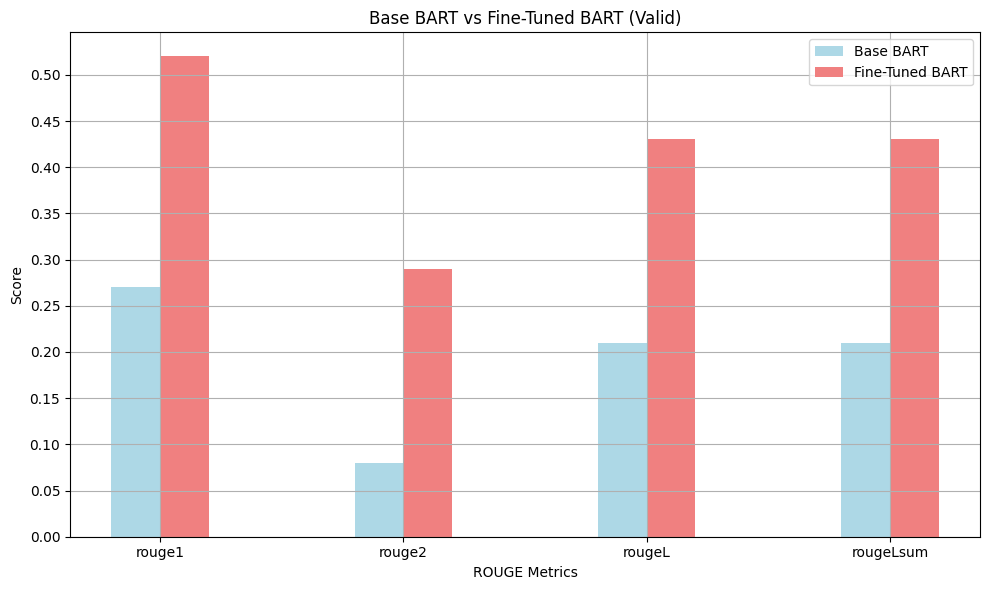

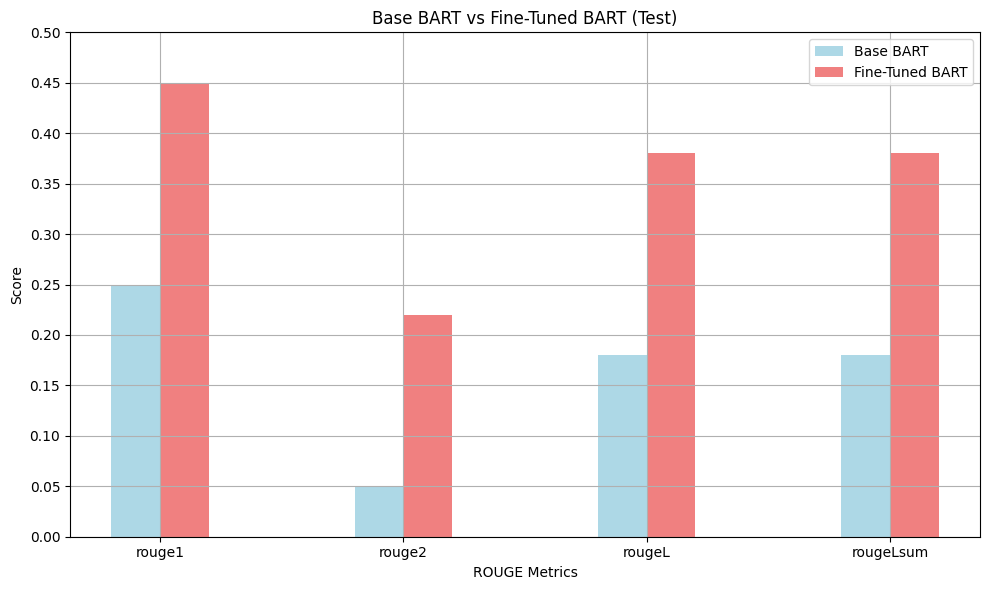

In [66]:
# Metrics
metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']

# Valid & Test values for Base & Fine-Tuned models
base_bart_valid = [0.27, 0.08, 0.21, 0.21]
base_bart_test = [0.25, 0.05, 0.18, 0.18]

fine_tuned_bart_valid = [0.52, 0.29, 0.43, 0.43]
fine_tuned_bart_test = [0.45, 0.22, 0.38, 0.38]

# Plot metrics
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, base_bart_valid, width, label="Base BART", color="lightblue")
ax.bar(x + width/2, fine_tuned_bart_valid, width, label="Fine-Tuned BART", color="lightcoral")
ax.set_xlabel("ROUGE Metrics")
ax.set_ylabel("Score")
ax.set_title("Base BART vs Fine-Tuned BART (Valid)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_yticks(np.arange(0, 0.55, 0.05))
ax.legend()
plt.tight_layout()
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, base_bart_test, width, label="Base BART", color="lightblue")
ax.bar(x + width/2, fine_tuned_bart_test, width, label="Fine-Tuned BART", color="lightcoral")
ax.set_xlabel("ROUGE Metrics")
ax.set_ylabel("Score")
ax.set_title("Base BART vs Fine-Tuned BART (Test)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_yticks(np.arange(0, 0.55, 0.05))
ax.legend()
plt.tight_layout()
plt.grid()
plt.show()